In [1]:
!pip install prophet
!pip install keras
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Function to clean and prepare data for a specific company
def prepare_data(company_data):
    company_data['Price'] = company_data['Price'].str.replace(',', '')  # Remove commas
    company_data['Cleaned_Price'] = company_data['Price'].str.extract('(\d+.\d+)').astype(float)
    company_data['Date'] = pd.to_datetime(company_data['Date'], errors='coerce')
    company_data.dropna(subset=['Date', 'Cleaned_Price'], inplace=True)
    return company_data

In [4]:
# Function to calculate and plot EMA, Bollinger Bands, and trading signals
def calculate_indicators_and_signals(company_data):
    company_data['EMA_20'] = company_data['Cleaned_Price'].ewm(span=20, adjust=False).mean()
    company_data['STD_20'] = company_data['Cleaned_Price'].rolling(window=20).std()
    company_data['Upper_Band'] = company_data['EMA_20'] + (company_data['STD_20'] * 2)
    company_data['Lower_Band'] = company_data['EMA_20'] - (company_data['STD_20'] * 2)
    company_data['Signal'] = 'Hold'
    company_data.loc[company_data['Cleaned_Price'] < company_data['Lower_Band'], 'Signal'] = 'Buy'
    company_data.loc[company_data['Cleaned_Price'] > company_data['Upper_Band'], 'Signal'] = 'Sell'
    return company_data

In [5]:
# Function to forecast using Facebook Prophet
def forecast_with_prophet(company_data):
    prophet_data = company_data[['Date', 'Cleaned_Price']].rename(columns={'Date': 'ds', 'Cleaned_Price': 'y'})
    model_prophet = Prophet(daily_seasonality=True)
    model_prophet.fit(prophet_data)
    future = model_prophet.make_future_dataframe(periods=90)  # Forecasting for 3 months ahead
    forecast = model_prophet.predict(future)
    return forecast

In [6]:
# Function to prepare data and train LSTM model
def train_lstm(company_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(company_data['Cleaned_Price'].values.reshape(-1, 1))
    
    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data) - time_step - 1):
            a = data[i:(i + time_step), 0]
            X.append(a)
            Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)
    
    time_step = 10
    X, y = create_dataset(scaled_data, time_step)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model_lstm.add(LSTM(50))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')
    model_lstm.fit(X, y, epochs=100, batch_size=1, verbose=2)
    
    train_predict = model_lstm.predict(X)
    train_predict = scaler.inverse_transform(train_predict)
    return train_predict

In [7]:
# Function to calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [8]:
# Function to simulate trading and evaluate capital returns
def simulate_trading(company_data):
    initial_capital = 10000.0
    capital = initial_capital
    positions = 0
    portfolio_values = []

    for index, row in company_data.iterrows():
        if row['Signal'] == 'Buy' and capital > 0:
            positions = capital / row['Cleaned_Price']
            capital = 0
        elif row['Signal'] == 'Sell' and positions > 0:
            capital = positions * row['Cleaned_Price']
            positions = 0
        portfolio_value = capital + (positions * row['Cleaned_Price'])
        portfolio_values.append(portfolio_value)

    final_portfolio_value = portfolio_values[-1]
    total_return = (final_portfolio_value - initial_capital) / initial_capital * 100

    plt.figure(figsize=(14,7))
    plt.plot(company_data['Date'], portfolio_values, label='Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value in $')
    plt.legend()
    plt.show()

    print(f"Total capital return over the period: {total_return:.2f}%")

    return total_return, portfolio_values

In [9]:
# Function to recommend BUY, HOLD, SELL decisions
def recommend_decisions(company_data):
    recommendations = []
    for index, row in company_data.iterrows():
        if row['Signal'] == 'Buy':
            recommendations.append('BUY')
        elif row['Signal'] == 'Sell':
            recommendations.append('SELL')
        else:
            recommendations.append('HOLD')
    company_data['Recommendation'] = recommendations
    return company_data



In [10]:
# Replace with actual sheet URLs
sheet_urls = {
    'EGYPT, Medinet Nasr Housing (MNHD)': 'https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/export?format=csv&gid=1827360014',
    'Colombia, Cementos Argos SA (CCB)': 'https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/export?format=csv&gid=690307818'
}

In [11]:
# Main analysis for each company (each sheet)
for sheet_name, sheet_url in sheet_urls.items():
    print(f"Analyzing data for: {sheet_name}")
    company_data = pd.read_csv(sheet_url)
    company_data = prepare_data(company_data)
    company_data = calculate_indicators_and_signals(company_data)

Analyzing data for: EGYPT, Medinet Nasr Housing (MNHD)
Analyzing data for: Colombia, Cementos Argos SA (CCB)


In [12]:
    # Forecast with Prophet and calculate MAPE
    forecast = forecast_with_prophet(company_data)
    prophet_mape = calculate_mape(company_data['Cleaned_Price'][:len(forecast)], forecast['yhat'][:len(company_data)])
    print(f"Prophet MAPE for {sheet_name}: {prophet_mape:.2f}%")


14:57:02 - cmdstanpy - INFO - Chain [1] start processing
14:57:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE for Colombia, Cementos Argos SA (CCB): 25.63%


In [13]:
    # Train LSTM and calculate MAPE
    train_predict = train_lstm(company_data)
    lstm_mape = calculate_mape(company_data['Cleaned_Price'][10:len(train_predict)+10], train_predict.flatten())
    print(f"LSTM MAPE for {sheet_name}: {lstm_mape:.2f}%")

C:\Users\MSD\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
292/292 - 3s - 12ms/step - loss: 0.0135
Epoch 2/100
292/292 - 1s - 3ms/step - loss: 0.0051
Epoch 3/100
292/292 - 1s - 3ms/step - loss: 0.0054
Epoch 4/100
292/292 - 1s - 3ms/step - loss: 0.0039
Epoch 5/100
292/292 - 1s - 3ms/step - loss: 0.0031
Epoch 6/100
292/292 - 1s - 3ms/step - loss: 0.0027
Epoch 7/100
292/292 - 1s - 5ms/step - loss: 0.0020
Epoch 8/100
292/292 - 1s - 3ms/step - loss: 0.0019
Epoch 9/100
292/292 - 1s - 3ms/step - loss: 0.0015
Epoch 10/100
292/292 - 1s - 2ms/step - loss: 0.0015
Epoch 11/100
292/292 - 1s - 3ms/step - loss: 0.0016
Epoch 12/100
292/292 - 1s - 4ms/step - loss: 0.0016
Epoch 13/100
292/292 - 1s - 3ms/step - loss: 0.0014
Epoch 14/100
292/292 - 1s - 4ms/step - loss: 0.0013
Epoch 15/100
292/292 - 1s - 3ms/step - loss: 0.0013
Epoch 16/100
292/292 - 1s - 3ms/step - loss: 0.0013
Epoch 17/100
292/292 - 1s - 5ms/step - loss: 0.0015
Epoch 18/100
292/292 - 1s - 3ms/step - loss: 0.0012
Epoch 19/100
292/292 - 1s - 4ms/step - loss: 0.0014
Epoch 20/100
292/292

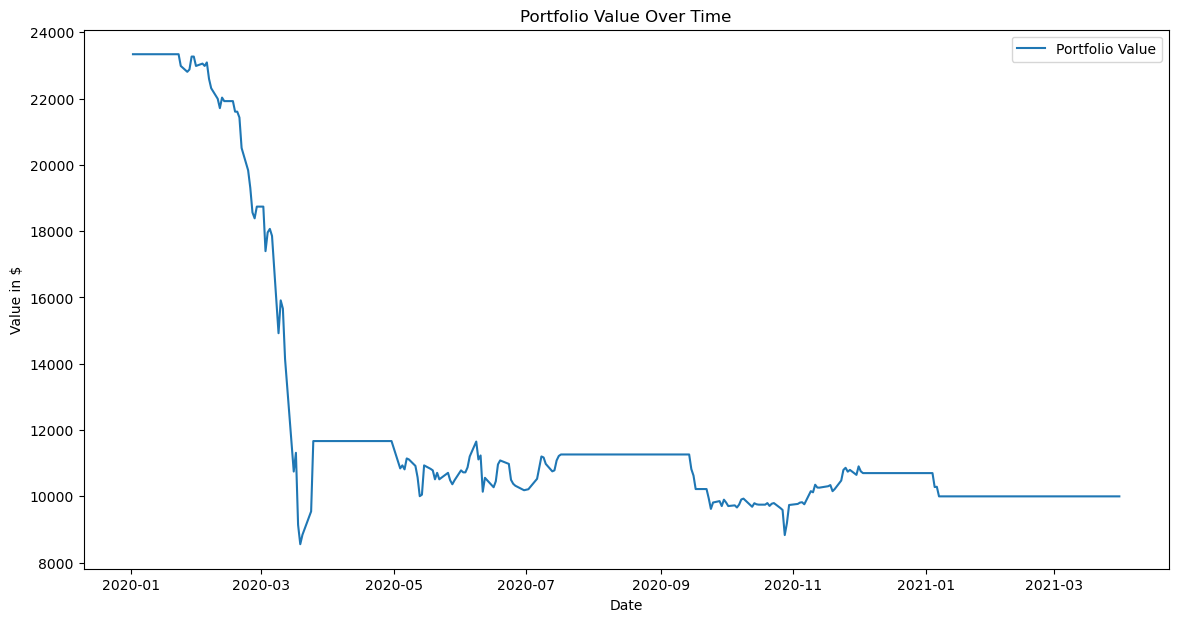

Total capital return over the period: 133.36%


In [14]:
    # Simulate trading
    total_return, portfolio_values = simulate_trading(company_data)

In [15]:
    # Recommend decisions
    company_data = recommend_decisions(company_data)
    print(company_data[['Date', 'Cleaned_Price', 'Recommendation']].head())

    # Save the recommendations to a CSV file
    company_data.to_csv(f'{sheet_name}_recommendations.csv', index=False)

        Date  Cleaned_Price Recommendation
0 2021-03-31         5150.0           HOLD
1 2021-03-30         5100.0           HOLD
2 2021-03-29         5045.0           HOLD
3 2021-03-26         5020.0           HOLD
4 2021-03-25         5030.0           HOLD
